In [ ]:
# Imports & Seeding
import os
import re
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# RSNA Dataset Definition
class RSNADataset(Dataset):
    def __init__(self, labels_path, patient_dir, transform=None):
        """
        2D: stacks three HU-windowed views (brain, subdural, bone)
        into a 3-channel tensor.
        """
        df = pd.read_csv(labels_path)
        self.transform = transform

        window_suffixes = ('_brain.png', '_subdural.png', '_bone.png')
        id2info = {}

        for pid in os.listdir(patient_dir):
            pid_folder = os.path.join(patient_dir, pid)
            if not os.path.isdir(pid_folder):
                continue

            for fname in os.listdir(pid_folder):
                if not fname.lower().endswith('.png'):
                    continue
                if not any(fname.lower().endswith(s) for s in window_suffixes):
                    continue

                base, _ = os.path.splitext(fname)
                # match e.g. "0001_ID_ab12cd34_brain"
                m = re.match(
                    r'^(?P<prefix>\d+_)(?P<id>ID_[0-9a-f]+)_(?:brain|subdural|bone)$',
                    base, flags=re.IGNORECASE
                )
                if not m:
                    continue

                prefix   = m.group('prefix')       # "0001_"
                image_id = m.group('id')           # "ID_ab12cd34"
                # record once per ID
                if image_id not in id2info:
                    id2info[image_id] = (pid_folder, prefix)

        # filter CSV to only those IDs
        df = df[df.ImageID.isin(id2info)].reset_index(drop=True)
        if df.empty:
            raise RuntimeError("No windowed PNGs found for any ImageID!")

        df['patient_folder'] = df.ImageID.map(lambda i: id2info[i][0])
        df['prefix']         = df.ImageID.map(lambda i: id2info[i][1])
        self.df = df
        self.label_cols = [
            'epidural', 'intraparenchymal', 'intraventricular',
            'subarachnoid', 'subdural'
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        folder = row.patient_folder
        pr     = row.prefix
        img_id = row.ImageID

        channels = []
        for win in ['brain', 'subdural', 'bone']:
            fname = f"{pr}{img_id}_{win}.png"
            path  = os.path.join(folder, fname)
            im    = Image.open(path).convert('L')
            if self.transform:
                im = self.transform(im)
            channels.append(im)           # each is [1,H,W]

        x = torch.cat(channels, dim=0)    # [3,H,W]
        y = row[self.label_cols].values.astype(np.float32)
        return x, torch.from_numpy(y)

In [ ]:
# LightningModule Definition
class EfficientNetRSNA(pl.LightningModule):
    def __init__(self, num_labels, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.net     = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_labels)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x,y = batch
        logits = self(x)
        loss   = self.loss_fn(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x,y = batch
        logits = self(x)
        loss   = self.loss_fn(logits, y)
        self.log('val_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# Prepare Dataset & DataLoaders
CSV_PATH    = 'labels.csv'
PATIENT_DIR = 'patient_images_0_1000'
k_neighbors = 1
batch_size  = 16
lr          = 1e-4
max_epochs  = 10

torch.manual_seed(seed)
np.random.seed(seed)

# Transforms and dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),           # now produces a 1×224×224 tensor per window
])
dataset = RSNADataset(CSV_PATH, PATIENT_DIR,
                      transform=train_transform)
print(f"Total slices: {len(dataset)}")

# Split 70/15/15
total      = len(dataset)
train_size = int(0.70 * total)
val_size   = int(0.15 * total)
test_size  = total - train_size - val_size

generator = torch.Generator().manual_seed(seed)
train_ds, val_ds, test_ds = random_split(dataset,
                                         [train_size, val_size, test_size],
                                         generator=generator)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

Total slices: 50863


In [ ]:
n = len(dataset)
train_size = int(0.75 * n)
val_size   = int(0.15 * n)
test_size  = n - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(f"Splits → Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Splits → Train: 38147, Val: 7629, Test: 5087


In [ ]:
# Train Model
num_labels = len(dataset.label_cols)
model = EfficientNetRSNA(num_labels=num_labels,
                         lr=lr)

trainer = pl.Trainer(max_epochs=max_epochs, accelerator="mps")
trainer.fit(model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | net     | EfficientNet      | 4.0 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.056    Total estimated model params size (MB)
250       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
from sklearn.metrics import f1_score

# Grid‐Search Thresholds on Validation Set
device = next(model.parameters()).device
model.eval()

# Collect probabilities and labels
all_probs_val, all_labels_val = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)).cpu().numpy()
        all_probs_val.append(probs)
        all_labels_val.append(yb.numpy())

probs_val  = np.vstack(all_probs_val)
labels_val = np.vstack(all_labels_val)

# Sweep for each class
label_names = dataset.label_cols
opt_thresholds = {}
for i, name in enumerate(label_names):
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0,1,101):
        preds = (probs_val[:, i] >= t).astype(int)
        f1    = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    opt_thresholds[name] = best_t
    print(f"{name:15s} → best threshold = {best_t:.2f}   (F1 = {best_f1:.4f})")

epidural        → best threshold = 0.18   (F1 = 0.8065)
intraparenchymal → best threshold = 0.42   (F1 = 0.8023)
intraventricular → best threshold = 0.44   (F1 = 0.7799)
subarachnoid    → best threshold = 0.19   (F1 = 0.7299)
subdural        → best threshold = 0.26   (F1 = 0.7832)


In [ ]:
# Final Evaluation on Test Set
all_probs_test, all_labels_test = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)).cpu().numpy()
        all_probs_test.append(probs)
        all_labels_test.append(yb.numpy())

probs_test  = np.vstack(all_probs_test)
labels_test = np.vstack(all_labels_test)

# Apply thresholds and compute F1 per class
thresh_arr = np.array([opt_thresholds[n] for n in label_names])
preds_test = (probs_test >= thresh_arr).astype(int)

print("\nTest set performance:")
for i, name in enumerate(label_names):
    f1 = f1_score(labels_test[:, i], preds_test[:, i], zero_division=0)
    print(f"  {name:15s} F1 = {f1:.4f}")

micro_f1 = f1_score(labels_test, preds_test, average='micro', zero_division=0)
macro_f1 = f1_score(labels_test, preds_test, average='macro', zero_division=0)
print(f"\n  Micro-averaged F1: {micro_f1:.4f}")
print(f"Macro-averaged F1: {macro_f1:.4f}")


Test set performance:
  epidural        F1 = 0.7500
  intraparenchymal F1 = 0.7900
  intraventricular F1 = 0.7740
  subarachnoid    F1 = 0.7539
  subdural        F1 = 0.7955

  Micro-averaged F1: 0.7797
Macro-averaged F1: 0.7727


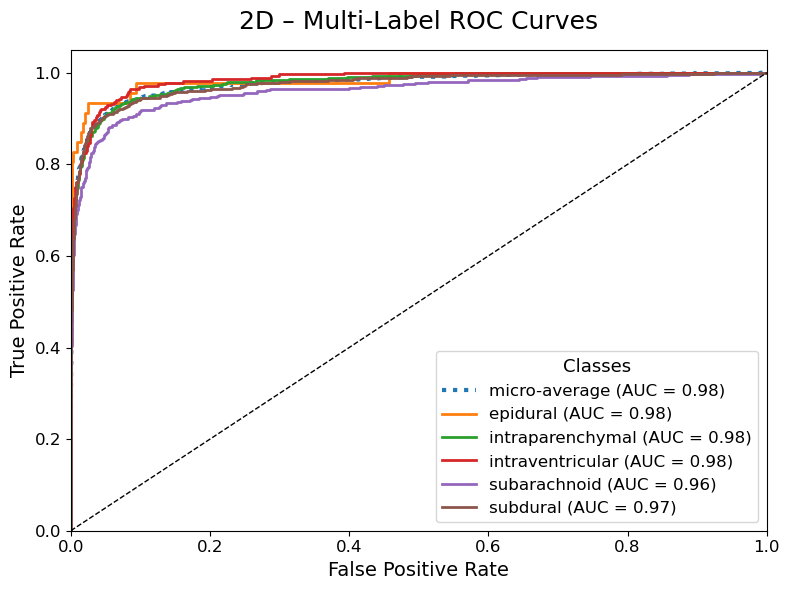

In [ ]:
# ROC-curve computation & plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, roc_auc = {}, {}, {}

for i, name in enumerate(label_names):
    if labels_test[:, i].sum() == 0:
        print(f"No positive samples for “{name}” in test set — skipping ROC.")
        continue
    
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(labels_test.ravel(), probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(8, 6))

# Micro-average
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
    linestyle=':', linewidth=3
)

# Per-class
for i, name in enumerate(label_names):
    if i not in fpr:
        continue
    plt.plot(
        fpr[i], tpr[i],
        lw=2,
        label=f"{name} (AUC = {roc_auc[i]:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title('2D – Multi-Label ROC Curves', fontsize=18, pad=15)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12, title="Classes", title_fontsize=13)
plt.tight_layout()
plt.savefig('roc_curves.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Test‐set size & confusion‐summary
num_test_samples = labels_test.shape[0]
print(f"Number of images in test set: {num_test_samples}\n")

# Boolean masks
tp_mask = (preds_test == 1) & (labels_test == 1)
tn_mask = (preds_test == 0) & (labels_test == 0)
fp_mask = (preds_test == 1) & (labels_test == 0)
fn_mask = (preds_test == 0) & (labels_test == 1)

total_tp = int(tp_mask.sum())
total_tn = int(tn_mask.sum())
total_fp = int(fp_mask.sum())
total_fn = int(fn_mask.sum())

print(f"Total true positives : {total_tp}")
print(f"Total true negatives : {total_tn}")
print(f"Total false positives: {total_fp}")
print(f"Total false negatives: {total_fn}\n")

# Per-class counts
print("Per-class breakdown:")
for i, name in enumerate(label_names):
    tp_i = int(tp_mask[:, i].sum())
    tn_i = int(tn_mask[:, i].sum())
    fp_i = int(fp_mask[:, i].sum())
    fn_i = int(fn_mask[:, i].sum())
    print(f"  {name:15s} TP = {tp_i:4d}   TN = {tn_i:6d}   FP = {fp_i:4d}   FN = {fn_i:4d}")

Number of images in test set: 7630

Total true positives : 1301
Total true negatives : 36114
Total false positives: 332
Total false negatives: 403

Per-class breakdown:
  epidural        TP =   33   TN =   7575   FP =    9   FN =   13
  intraparenchymal TP =  346   TN =   7100   FP =   82   FN =  102
  intraventricular TP =  214   TN =   7291   FP =   58   FN =   67
  subarachnoid    TP =  288   TN =   7154   FP =   59   FN =  129
  subdural        TP =  420   TN =   6994   FP =  124   FN =   92


In [ ]:
# Image-level perfect-classification count
perfect_mask = np.all(preds_test == labels_test, axis=1)

num_perfect = int(perfect_mask.sum())
num_images  = labels_test.shape[0]
pct_perfect = num_perfect / num_images * 100

print(f"Images perfectly classified across all {labels_test.shape[1]} labels: {num_perfect} / {num_images} "
      f"({pct_perfect:.1f}%)")

Images perfectly classified across all 5 labels: 6985 / 7630 (91.5%)
